In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')




In [3]:
df = pd.read_csv("cleaned_dataset.csv")

if 'Date/Time' in df.columns:
    df['Date/Time'] = pd.to_datetime(df['Date/Time'])
else:
    raise ValueError("COLUMN IS NOT HERE")
df.head()

,Text,Sentiment,Source,Date/Time,User ID,Location,Confidence Score,Product/Service,Category,Rating,Response Time (mins),Resolution Status,Cleaned_Text,Processed_Text
0,"It was okay, nothing special.",Neutral,Website Testimonial,2023-08-29 06:04:00,user10000,Toronto,0.78,Website,Customer Support,4,152,Resolved,it was okay nothing special,okay nothing special
1,Received wrong item.,Negative,Amazon Reviews,2023-06-01 09:31:00,user10001,Toronto,0.88,Mobile App,Delivery,5,133,Resolved,received wrong item,received wrong item
2,Product quality is acceptable.,Neutral,Website Testimonial,2023-09-16 21:12:00,user10002,London,0.76,Gift Card,Usability,5,103,Resolved,product quality is acceptable,product quality acceptable
3,Slow response from team.,Negative,Yelp,2023-08-26 02:44:00,user10003,Berlin,0.74,Website,Billing,3,134,Escalated,slow response from team,slow response team
4,Great quality and quick delivery.,Positive,TripAdvisor,2023-06-23 16:11:00,user10004,Paris,0.71,Delivery Service,Billing,3,165,Resolved,great quality and quick delivery,great quality quick delivery


🧾 Negative feedback count: 399
⚠️ Top recurring complaint keywords (Negative Reviews Only):
customer                   60
customer support           60
replied                    60
support                    60
support replied            60
item                       56
received                   56
received wrong             56
wrong                      56
wrong item                 56
delivery                   50
delivery took              50
long                       50
took                       50
took long                  50
chatbot                    48
chatbot useless            48
response                   48
response team              48
slow                       48


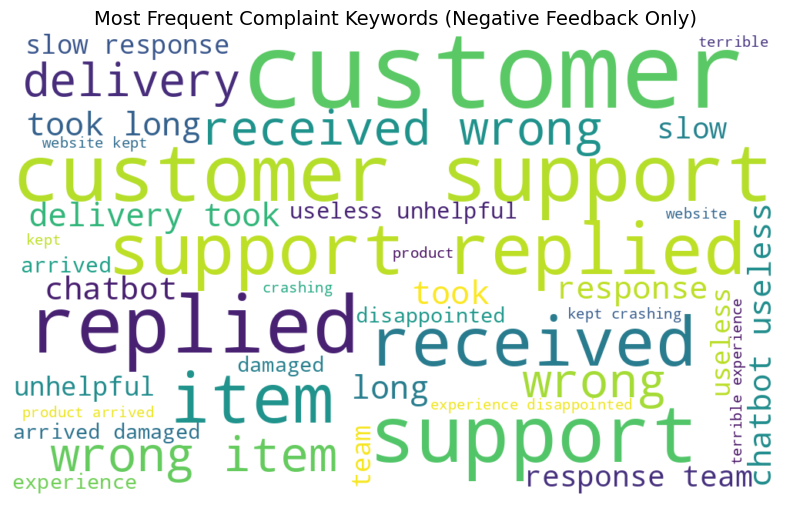

In [4]:

text_column = 'Processed_Text'

df['Sentiment'] = df['Sentiment'].astype(str).str.strip().str.lower()
neg_df = df[df['Sentiment'] == 'negative']

print(f"🧾 Negative feedback count: {len(neg_df)}")

vectorizer = CountVectorizer(ngram_range=(1,2), stop_words='english')
X = vectorizer.fit_transform(neg_df[text_column].astype(str))

word_freq = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1))
top_complaints = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]

print("⚠️ Top recurring complaint keywords (Negative Reviews Only):")
for word, freq in top_complaints:
    print(f"{word:25s}  {freq}")

wc = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Complaint Keywords (Negative Feedback Only)", fontsize=14)
plt.show()

In [5]:
print(df.columns.tolist())


['Text', 'Sentiment', 'Source', 'Date/Time', 'User ID', 'Location', 'Confidence Score', 'Product/Service', 'Category', 'Rating', 'Response Time (mins)', 'Resolution Status', 'Cleaned_Text', 'Processed_Text']


In [6]:
sentiment_map = {
    'negative': 1,
    'neutral': 2,
    'positive': 3,
}

df['Sentiment_Score'] = df['Sentiment'].str.lower().map(sentiment_map)

df = df.dropna(subset=['Sentiment_Score'])
df[['Sentiment', 'Sentiment_Score']].head()



,Sentiment,Sentiment_Score
0,neutral,2
1,negative,1
2,neutral,2
3,negative,1
4,positive,3


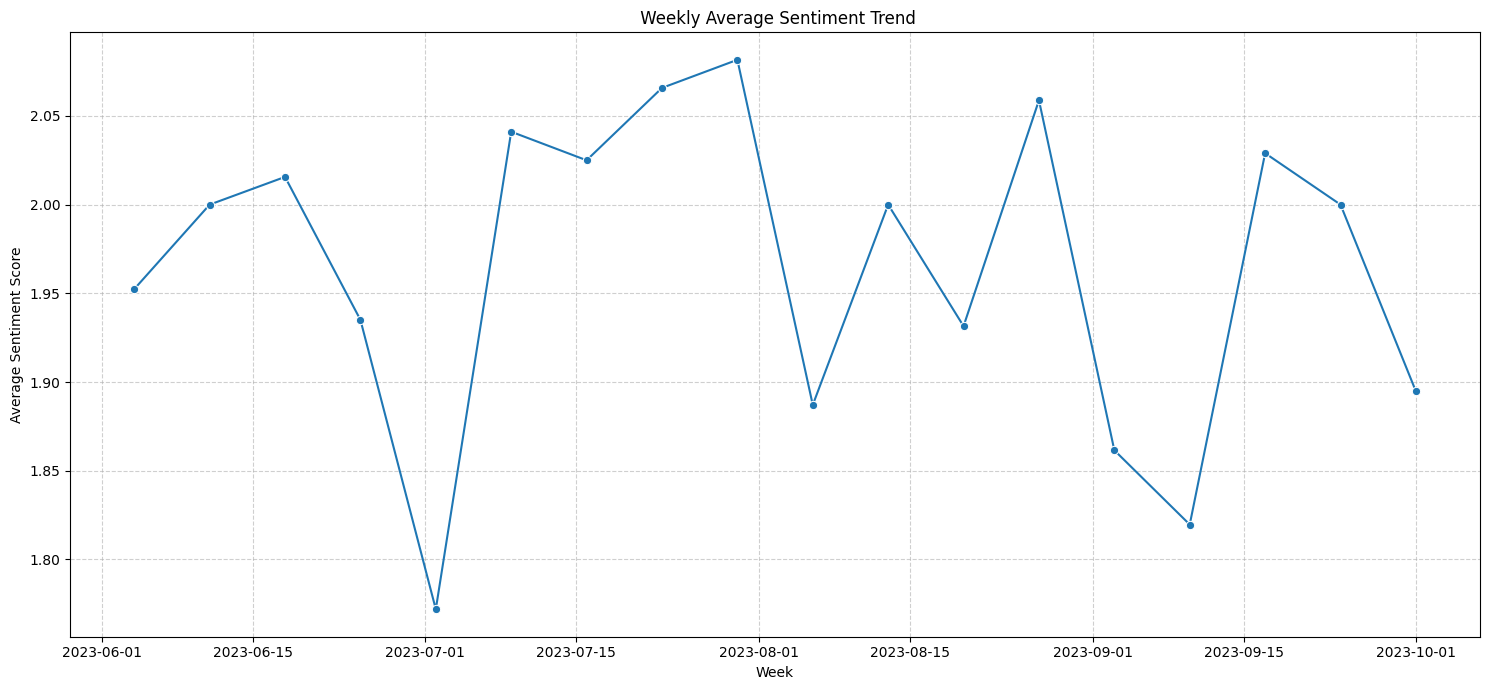

In [7]:

df['Date/Time'] = pd.to_datetime(df['Date/Time'])
new_df = (
    df.groupby(pd.Grouper(key='Date/Time', freq='W'))['Sentiment_Score']
      .mean()
      .reset_index()
)


new_df = new_df.dropna(subset=['Sentiment_Score'])


plt.figure(figsize=(15, 7))
sns.lineplot(data=new_df, x='Date/Time', y='Sentiment_Score', marker='o')
plt.title(" Weekly Average Sentiment Trend")
plt.xlabel("Week")
plt.ylabel("Average Sentiment Score")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


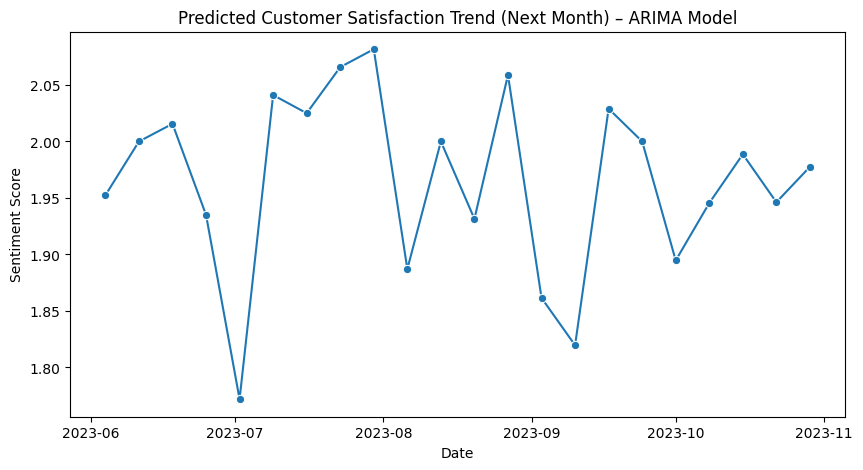

,Date/Time,Predicted_Sentiment_Score
18,2023-10-08,1.945513
19,2023-10-15,1.988697
20,2023-10-22,1.946245
21,2023-10-29,1.977605


In [8]:

from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

new_df = (
    df.groupby(pd.Grouper(key='Date/Time', freq='W'))['Sentiment_Score']
      .mean().reset_index()
)
new_df = new_df.dropna()

model = ARIMA(new_df['Sentiment_Score'], order=(2,1,2))
model_fit = model.fit()

forecast_steps = 4
forecast = model_fit.forecast(steps=forecast_steps)
future_dates = pd.date_range(
    start=new_df['Date/Time'].iloc[-1] + pd.Timedelta(weeks=1),
    periods=forecast_steps, freq='W'
)

forecast_df = pd.DataFrame({'Date/Time': future_dates, 'Predicted_Sentiment_Score': forecast})
all_data = pd.concat([
    new_df.rename(columns={'Sentiment_Score': 'Predicted_Sentiment_Score'}),
    forecast_df
])

plt.figure(figsize=(10,5))
sns.lineplot(data=all_data, x='Date/Time', y='Predicted_Sentiment_Score', marker='o')
plt.title("Predicted Customer Satisfaction Trend (Next Month) – ARIMA Model")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.show()

forecast_df


In [9]:
pip install reportlab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.9 MB/s eta 0:00:00


In [10]:
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet

plt.figure(figsize=(8,4))
plt.plot(new_df['Date/Time'], new_df['Sentiment_Score'], marker='o', label='Past Trend')
plt.plot(forecast_df['Date/Time'], forecast_df['Predicted_Sentiment_Score'], linestyle='--', label='Forecast')
plt.title("Customer Sentiment Forecast Trend")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("sentiment_forecast_chart.png")
plt.close()

last_score = new_df['Sentiment_Score'].iloc[-1]
future_avg = forecast_df['Predicted_Sentiment_Score'].mean()

if future_avg > last_score:
    trend_text = "Customer satisfaction is expected to improve next month."
elif future_avg < last_score:
    trend_text = "Customer satisfaction may slightly decline in the next few weeks."
else:
    trend_text = "Customer satisfaction levels are likely to remain steady."


report = SimpleDocTemplate("AI_insights_report.pdf", pagesize=A4)
styles = getSampleStyleSheet()
content = []

content.append(Paragraph("AI Insights Report", styles["Title"]))
content.append(Spacer(1, 12))

content.append(Paragraph("This report summarizes the analyzed data and predicts customer satisfaction trends using a time-series model.", styles["Normal"]))
content.append(Spacer(1, 12))

content.append(Paragraph(f"<b>Last Recorded Sentiment Score:</b> {last_score:.2f}", styles["Normal"]))
content.append(Paragraph(f"<b>Average Predicted Score (Next Month):</b> {future_avg:.2f}", styles["Normal"]))
content.append(Spacer(1, 12))

content.append(Paragraph(trend_text, styles["Normal"]))
content.append(Spacer(1, 12))

content.append(Paragraph("Below is a visual chart showing past and future sentiment trends.", styles["Normal"]))
content.append(Spacer(1, 12))
content.append(Image("sentiment_forecast_chart.png", width=400, height=200))
content.append(Spacer(1, 12))

content.append(Paragraph("These insights can help the company take proactive steps to maintain and improve customer satisfaction.", styles["Normal"]))
content.append(Spacer(1, 12))

content.append(Paragraph("Report generated automatically using kunal python tool.", styles["Italic"]))

report.build(content)
print("✅ AI_insights_report.pdf created successfully with chart and insights.")




✅ AI_insights_report.pdf created successfully with chart and insights.
